In [1]:
import os
import pathlib

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

DIR_HOME = pathlib.Path("..").absolute()
DIR_EVAL = DIR_HOME / "data" / "evaluations"

<Axes: xlabel='NDCG@10', ylabel='Dataset Name'>

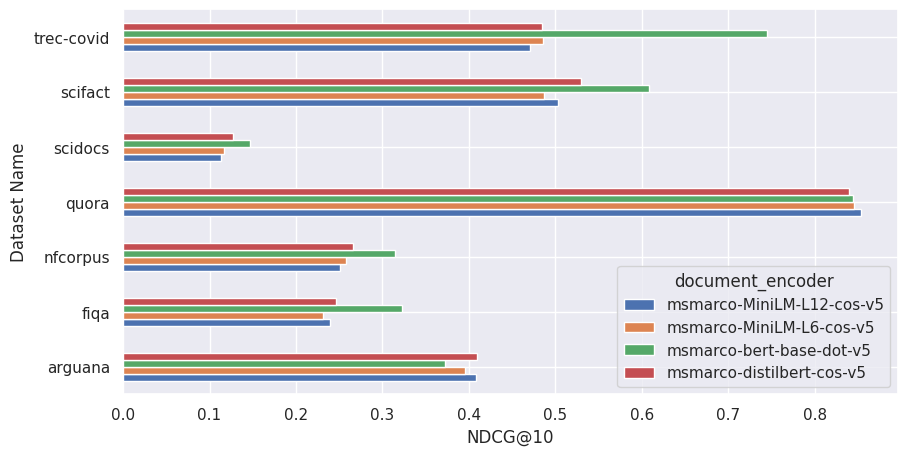

In [2]:
df_no_distill = pd.read_csv(DIR_EVAL / "eval_results_symmetric.csv")
df_no_distill.pivot(index="dataset_name",
                    columns="document_encoder",
                    values="NDCG@10") \
             .plot.barh(figsize=(10, 5),
                        xlabel="NDCG@10",
                        ylabel="Dataset Name")

<Axes: xlabel='Dataset Name', ylabel='NDCG@10'>

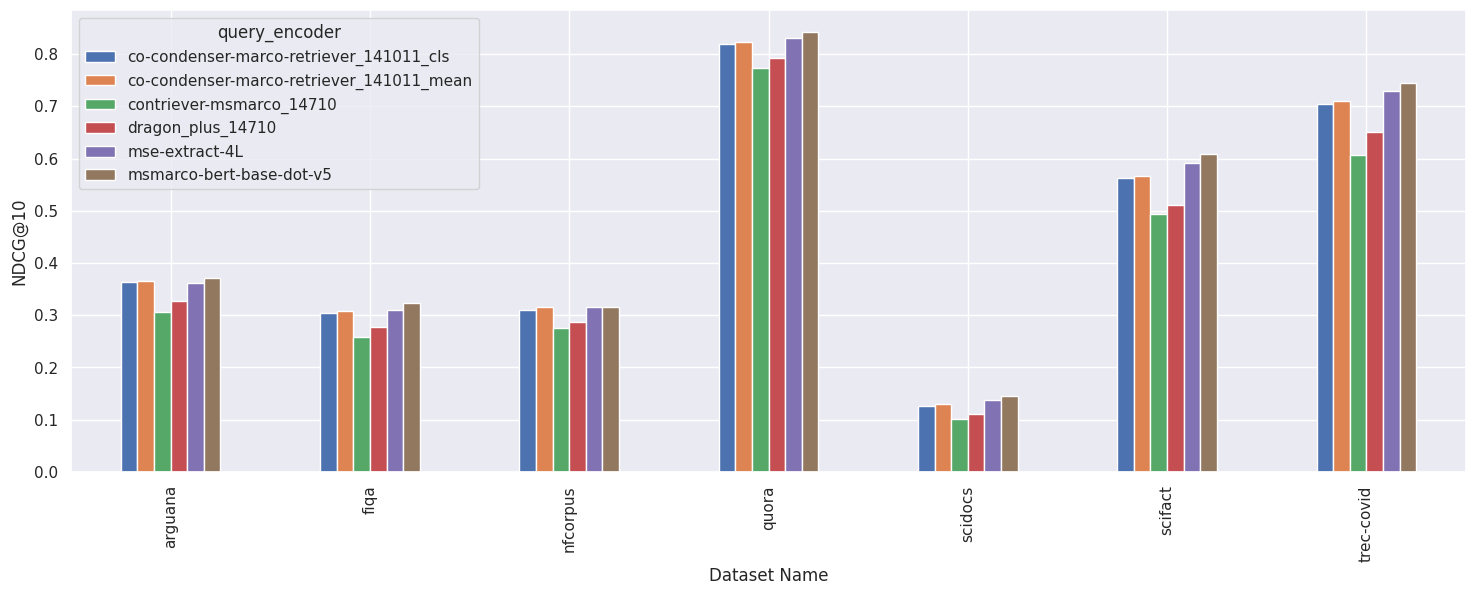

In [4]:
df_distill = pd.read_csv(DIR_EVAL / "eval_results_distill_4L.csv")
df_distill.pivot(index="dataset_name",
                 columns="query_encoder",
                 values="NDCG@10") \
          .plot.bar(figsize=(18, 6),
                    ylabel="NDCG@10",
                    xlabel="Dataset Name")